<a href="https://www.kaggle.com/code/rohinimaldhure/retailrocket-recommender-system-dataset-project?scriptVersionId=157988732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import seaborn as sns


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-dataset/item_properties_part1.csv
/kaggle/input/ecommerce-dataset/category_tree.csv
/kaggle/input/ecommerce-dataset/item_properties_part2.csv
/kaggle/input/ecommerce-dataset/events.csv


**Retail Rocket is a company that provides personalized real-time recommendations for web shoppers,Retail Rocket's services typically involve utilizing recommendation algorithms to analyze user behavior, preferences, and historical data to deliver personalized product recommendations**

**Retail Rocket typically starts by collecting and analyzing user behavior data. This data includes information on users' browsing history, product views, clicks, purchases, and other interactions on the e-commerce platform**

**The dataset consists of three files: a file with behaviour data (events.csv), a file with item properties (item_properties.сsv) and a file, which describes category tree (category_tree.сsv),The behaviour data, i.e. events like clicks, add to carts, transactions, represent interactions ,A visitor can make three types of events, namely “view”, “addtocart” or “transaction”**

**Task1 :To predict properties of items in "addtocart" events based on "view" events,Implement collaborative filtering to find patterns based on user behavior**


In [2]:
# Load the events data
event_df=pd.read_csv('/kaggle/input/ecommerce-dataset/events.csv')
event_df

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


**Category IDs explain the relationship of different products with each other e.g. Category ID 1016 is a child of Parent ID 213**

In [3]:
# Load the category tree data
category_tree=pd.read_csv('/kaggle/input/ecommerce-dataset/category_tree.csv')

category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [4]:

# load item-related datasets
item1=pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part1.csv')
item2=pd.read_csv('/kaggle/input/ecommerce-dataset/item_properties_part2.csv')

# Combine the item properties dataframes
item_properties = pd.concat([item1, item2])
item_properties.head(10)


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
5,1436065200000,285026,available,0
6,1434250800000,89534,213,1121373
7,1431831600000,264312,6,319724
8,1433646000000,229370,202,1330310
9,1434250800000,98113,451,1141052 n48.000


**Below shows the number of items under category id 1016**

In [5]:
item_properties.loc[(item_properties.property == 'categoryid')&(item_properties.value== '1016')].head()

,timestamp,itemid,property,value
234908,1435460400000,73730,categoryid,1016
430468,1435460400000,201154,categoryid,1016
676270,1433041200000,29689,categoryid,1016
783306,1433041200000,235999,categoryid,1016
970935,1431226800000,362999,categoryid,1016


In [6]:
# view the number of data
event_df.shape

(2756101, 5)

In [7]:
category_tree.shape

(1669, 2)

In [8]:
item_properties.shape

(20275902, 4)

In [9]:
event_df.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [10]:
#event_count
event_count=event_df.event.value_counts()
event_count

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [11]:
#event_percentage
event_percentage =(event_count /len(event_df))*100
event_percentage

event
view           96.669607
addtocart       2.515583
transaction     0.814810
Name: count, dtype: float64

In [12]:
event_df.groupby('event')['transactionid'].count()

event
addtocart          0
transaction    22457
view               0
Name: transactionid, dtype: int64

In [13]:
event_df.groupby('event')['visitorid'].count()

event
addtocart        69332
transaction      22457
view           2664312
Name: visitorid, dtype: int64

In [14]:
# remove duplicates if any

# Print the number of rows before removing duplicates
print('Number of rows before removing duplicates: ', event_df.shape[0])

# Remove duplicates based on all columns
event_df.drop_duplicates(inplace=True)

# Reset the index
event_df.reset_index(drop=True, inplace=True)

# Print the number of rows after removing duplicates
print('Number of rows after removing duplicates: ', event_df.shape[0])


Number of rows before removing duplicates:  2756101
Number of rows after removing duplicates:  2755641


**As dates in current dataset is in unix timestamp , I'll convert them into readable dates**

In [15]:

event_df['date_time'] = pd.to_datetime(event_df['timestamp'],unit='ms')
event_df['date_time']


0         2015-06-02 05:02:12.117
1         2015-06-02 05:50:14.164
2         2015-06-02 05:13:19.827
3         2015-06-02 05:12:35.914
4         2015-06-02 05:02:17.106
                    ...          
2755636   2015-08-01 03:13:05.939
2755637   2015-08-01 03:30:13.142
2755638   2015-08-01 02:57:00.527
2755639   2015-08-01 03:08:50.703
2755640   2015-08-01 03:36:03.914
Name: date_time, Length: 2755641, dtype: datetime64[ns]

In [16]:
event_df.head(10)

,timestamp,visitorid,event,itemid,transactionid,date_time
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106
5,1433224086234,972639,view,22556,NaN,2015-06-02 05:48:06.234
6,1433221923240,810725,view,443030,NaN,2015-06-02 05:12:03.240
7,1433223291897,794181,view,439202,NaN,2015-06-02 05:34:51.897
8,1433220899221,824915,view,428805,NaN,2015-06-02 04:54:59.221
9,1433221204592,339335,view,82389,NaN,2015-06-02 05:00:04.592


In [17]:
print('start Date of dataset: ' ,event_df['date_time'].min())

print('End Date of Dataset : ', event_df['date_time'].max())

start Date of dataset:  2015-05-03 03:00:04.384000
End Date of Dataset :  2015-09-18 02:59:47.788000


**It shows How many times did a customer view an item before making purchase decision?**

In [18]:
#This DataFrame contains only the rows where the 'event' is 'transaction' and the selected columns 'visitorid,' 'itemid,' and 'date_time.' 
#It allows you to focus on data related to transaction events for further analysis or processing.

item_tra=event_df[['visitorid','itemid','date_time']][event_df['event']=='transaction']
print(item_tra.head().reset_index())

#This DataFrame contains only the rows where the 'event' is 'view' and the selected columns 'visitorid,' 'itemid,' and 'date_time.' 
#It allows you to focus on data related to view events for further analysis or processing.

item_view =event_df[['visitorid','itemid','date_time']][event_df['event']=='view']
print(item_view.head().reset_index())

#This DataFrame contains only the rows where the 'event' is 'addtocart' and the selected columns 'visitorid,' 'itemid,' and 'date_time.'
#It allows you to focus on data related to  addtocart events for further analysis or processing.

item_atc =event_df[['visitorid','itemid','date_time']][event_df['event']=='addtocart']
print(item_atc.head().reset_index())



   index  visitorid  itemid               date_time
0    130     599528  356475 2015-06-02 05:17:56.276
1    304     121688   15335 2015-06-01 21:18:20.981
2    418     552148   81345 2015-06-01 21:25:15.008
3    814     102019  150318 2015-06-01 16:38:56.375
4    843     189384  310791 2015-06-01 16:01:58.180
   index  visitorid  itemid               date_time
0      0     257597  355908 2015-06-02 05:02:12.117
1      1     992329  248676 2015-06-02 05:50:14.164
2      2     111016  318965 2015-06-02 05:13:19.827
3      3     483717  253185 2015-06-02 05:12:35.914
4      4     951259  367447 2015-06-02 05:02:17.106
   index  visitorid  itemid               date_time
0     17     287857    5206 2015-06-02 05:33:56.124
1     19     158090   10572 2015-06-02 04:57:58.505
2     63    1193904  255275 2015-06-02 05:39:03.021
3    112     599528  356475 2015-06-02 05:12:21.632
4    179     105775  312728 2015-06-02 04:54:40.956


In [19]:
#create dataframe of visitorid,itemid found in all three event

m=item_tra.merge(item_atc, on=['visitorid','itemid'],how ='inner' , suffixes=['(transaction)','(addtocart)'])
m=m.merge(item_view, on=['visitorid','itemid'],how ='inner',suffixes =['(view)'])
m=m.rename(columns={'date_time' : 'date_time (view)'})
m.head(10)

,visitorid,itemid,date_time(transaction),date_time(addtocart),date_time (view)
0,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-02 05:11:36.102
1,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-03 02:12:25.235
2,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-06 21:10:10.602
3,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-08 02:44:57.480
4,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 00:34:37.794
5,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 00:34:09.376
6,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 18:22:47.121
7,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 18:17:39.198
8,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 19:05:02.402
9,599528,356475,2015-06-02 05:17:56.276,2015-06-02 05:12:21.632,2015-06-10 21:57:42.396


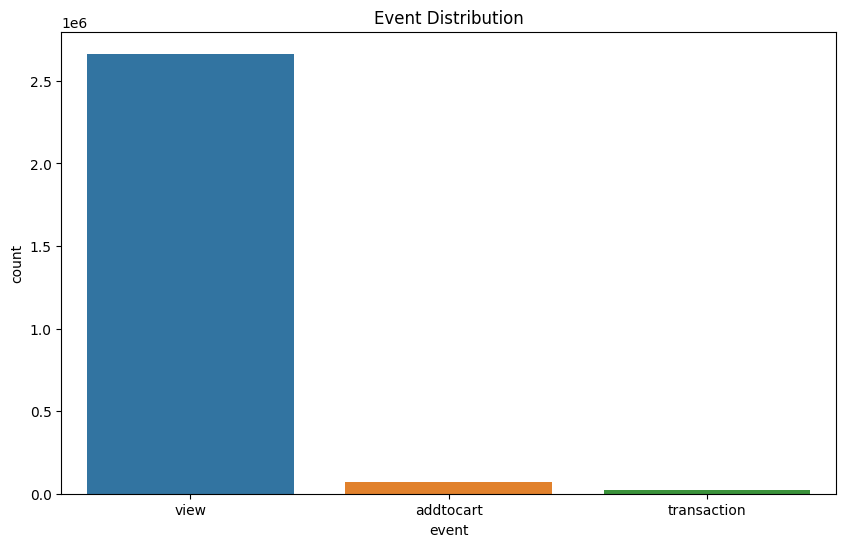

In [20]:
# 1. Events distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=event_df, x='event')
plt.title('Event Distribution')
plt.show()

**This is to create a histogram (a countplot) that visualizes the distribution of different event types in the dataset. To provide a visual representation of how often each event type occurs in the dataset**

**View' event is the most common, representing 96.67% of the events,'Add to cart' events occupy for 2.52% of the total, and 'Transaction' events occupy 0.81%**.

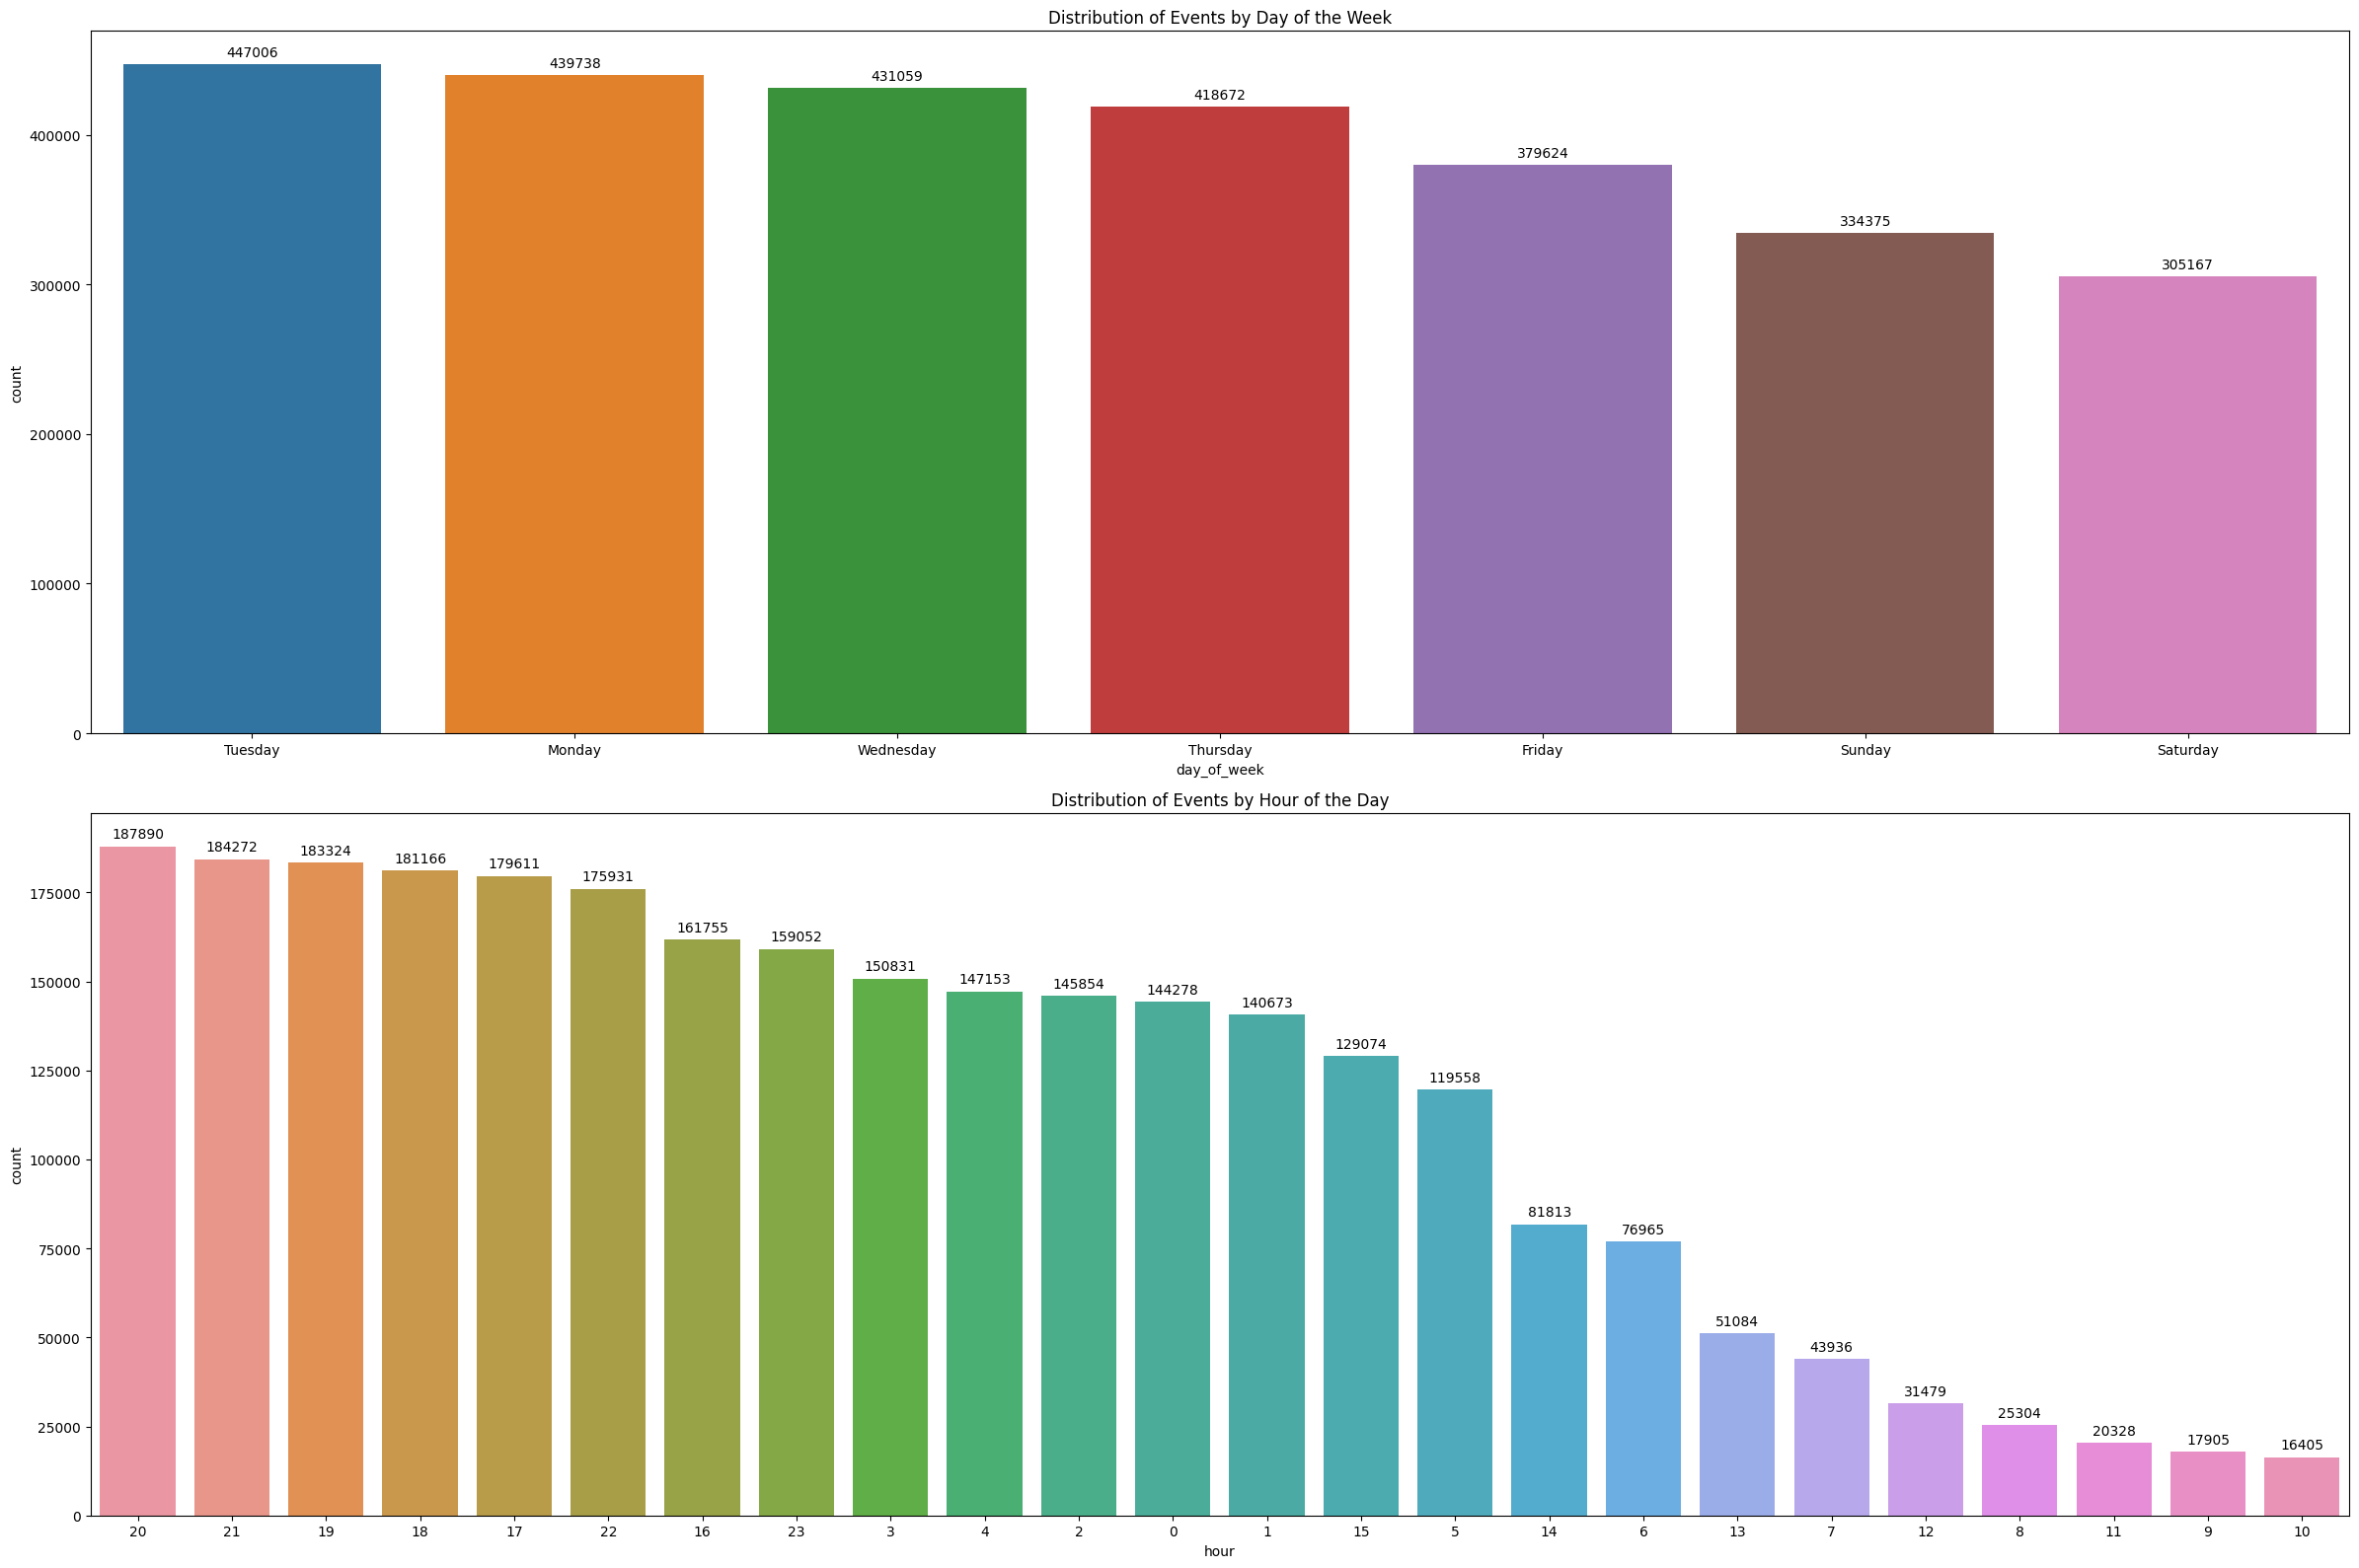

In [21]:
 # distribution of events by day of the week and hour of the day. 
event_df['day_of_week'] = event_df['date_time'].dt.day_name()
event_df['hour'] = event_df['date_time'].dt.hour

plt.figure(figsize=(24, 16))

plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=event_df, x='day_of_week', order=event_df['day_of_week'].value_counts().index)
plt.title('Distribution of Events by Day of the Week')
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.subplot(2, 1, 2)
ax2 = sns.countplot(data=event_df, x='hour', order=event_df['hour'].value_counts().index)
plt.title('Distribution of Events by Hour of the Day')
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.show()


**create a new DataFrame (events_daily) where the events are aggregated on a daily basis, and the resulting DataFrame shows the count of events for each day**

In [22]:
# Events over time
events_daily = event_df.resample('D', on='date_time').count()
events_daily

,timestamp,visitorid,event,itemid,transactionid,day_of_week,hour
date_time,,,,,,,
2015-05-03,13682,13682,13682,13682,83,13682,13682
2015-05-04,19413,19413,19413,19413,154,19413,19413
2015-05-05,23011,23011,23011,23011,225,23011,23011
2015-05-06,23920,23920,23920,23920,258,23920,23920
2015-05-07,23157,23157,23157,23157,217,23157,23157
...,...,...,...,...,...,...,...
2015-09-14,20905,20905,20905,20905,154,20905,20905
2015-09-15,20425,20425,20425,20425,158,20425,20425
2015-09-16,11494,11494,11494,11494,137,11494,11494


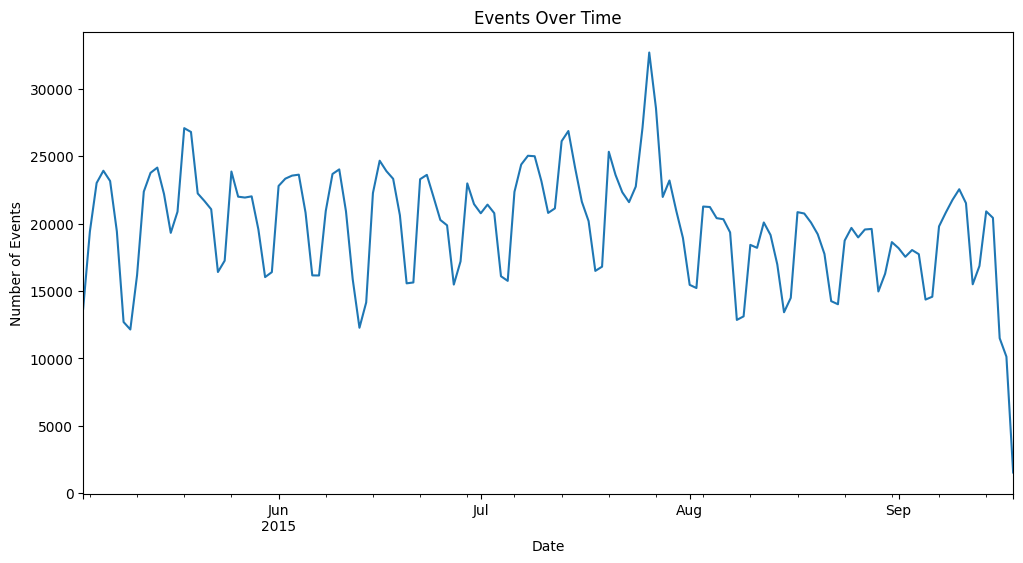

In [23]:
# 2. Events over time plot

plt.figure(figsize=(12, 6))
events_daily['event'].plot()
plt.title('Events Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.show()

visitorid
1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
371606     2345
286616     2252
684514     2246
892013     2024
861299     1991
Name: count, dtype: int64


Text(0, 0.5, 'number of event')

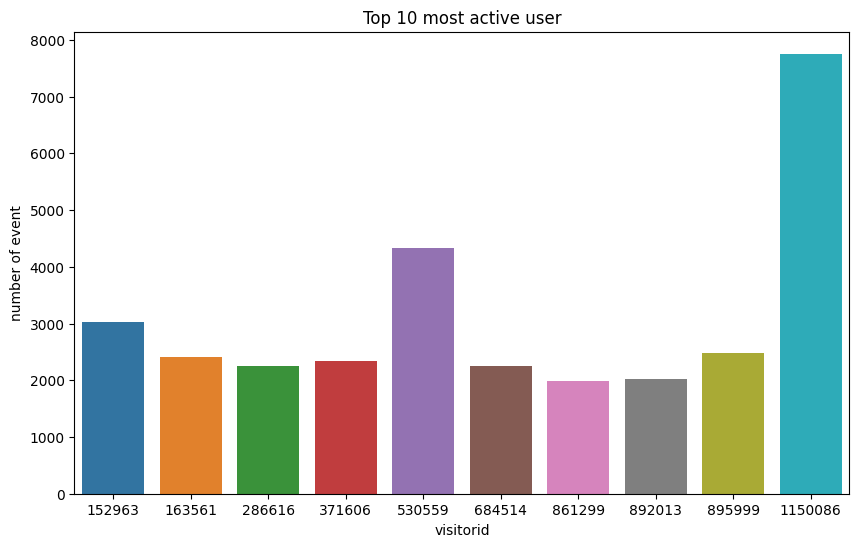

In [24]:
#most Active users
top_most_active_user=event_df['visitorid'].value_counts().head(10)
print(top_most_active_user)
plt.figure(figsize=(10,6))
sns.barplot(x=top_most_active_user.index,y=top_most_active_user.values)
plt.title('Top 10 most active user')
plt.xlabel('visitorid')
plt.ylabel('number of event')

**A bar plot to visualize the top 10 viewed items based on the 'itemid' column in from DataFrame**

itemid
187946    3410
461686    2538
5411      2325
370653    1854
219512    1740
298009    1642
96924     1633
309778    1565
257040    1531
384302    1528
Name: count, dtype: int64


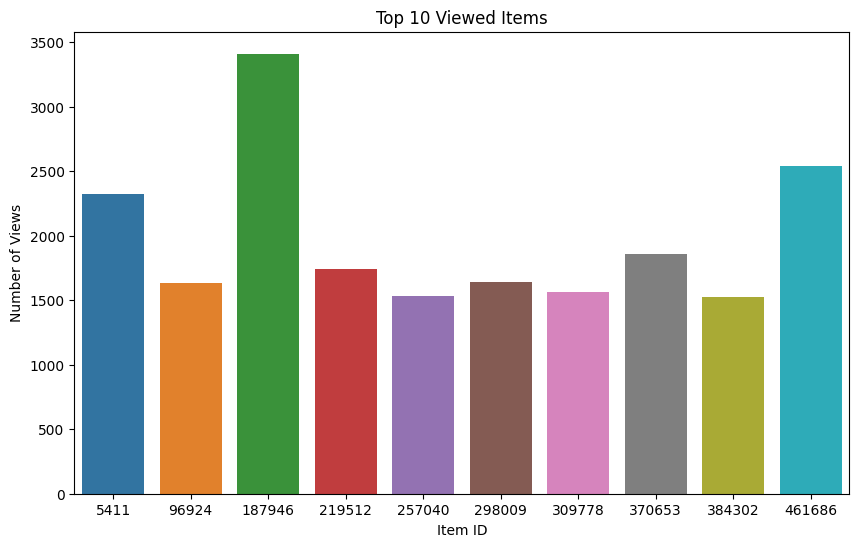

In [25]:
# 3. Top items by views
top_viewed_items = event_df[event_df['event'] == 'view']['itemid'].value_counts().head(10)
print(top_viewed_items)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_viewed_items.index, y=top_viewed_items.values)
plt.title('Top 10 Viewed Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

In [26]:
event_df.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5


**A bar plot to visualize the top 10 sold items based on the 'itemid' column from DataFrame**

itemid
461686    133
119736     97
213834     92
312728     46
7943       46
445351     45
48030      41
420960     38
248455     38
17478      37
Name: count, dtype: int64


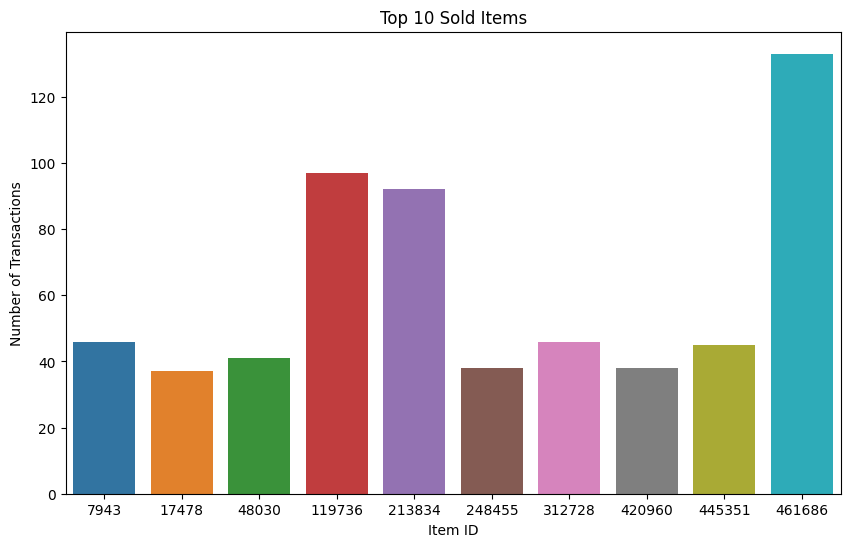

In [27]:
#  Top items by transactions
top_sold_items = event_df[event_df['event'] == 'transaction']['itemid'].value_counts().head(10)
print(top_sold_items)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_sold_items.index, y=top_sold_items.values)
plt.title('Top 10 Sold Items')
plt.xlabel('Item ID')
plt.ylabel('Number of Transactions')
plt.show()


itemid
461686    304
312728    161
409804    152
320130    141
29196     135
7943       97
48030      95
441852     90
445351     89
257040     89
Name: count, dtype: int64


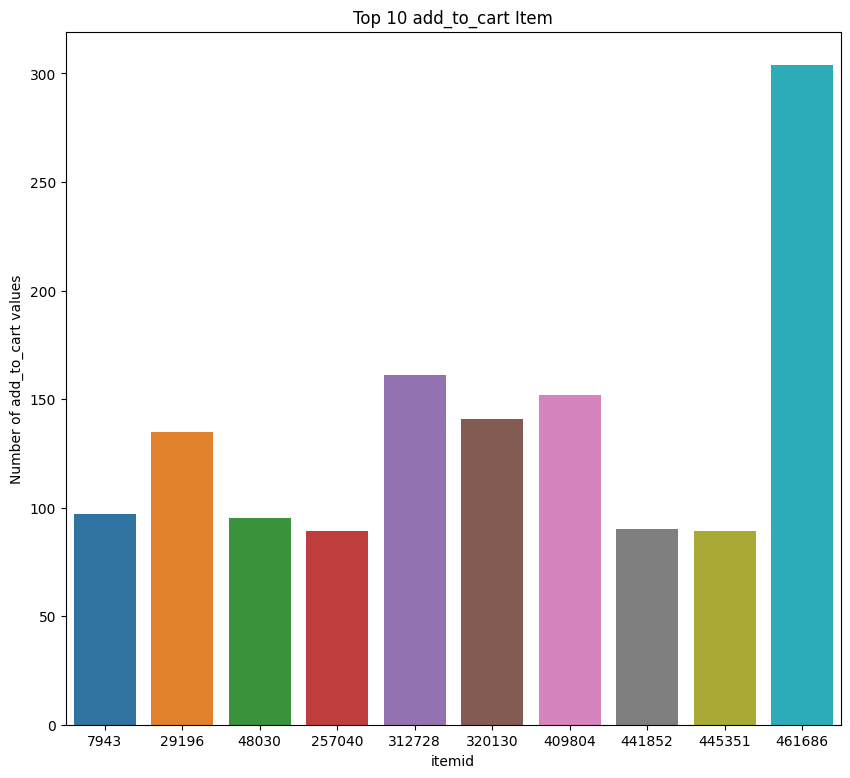

In [28]:
# Top item by addtocart
top_addtocart_item =event_df[event_df['event']=='addtocart']['itemid'].value_counts().head(10)
print(top_addtocart_item)

plt.figure(figsize=(10,9))
sns.barplot(x=top_addtocart_item.index ,y =top_addtocart_item.values)
plt.title('Top 10 add_to_cart Item')
plt.xlabel('itemid')
plt.ylabel('Number of add_to_cart values')

plt.show()

In [29]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [30]:
item_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [31]:
#Merge events with item properties and category tree
merged_events = event_df.merge(item_properties,on=['itemid','timestamp'],how='left')
merged_events.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5,NaN,NaN


In [32]:
merged_events=merged_events.merge(category_tree, left_on='property', right_on='categoryid', how='left')
merged_events.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5,NaN,NaN,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5,NaN,NaN,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5,NaN,NaN,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5,NaN,NaN,NaN,NaN


In [33]:
# 6. Top categories by views
top_categories_views = merged_events[merged_events['event'] == 'view']['parentid'].value_counts().head(10)

if not top_categories_views.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories_views.index, y=top_categories_views.values)
    plt.title('Top 10 Categories by Views')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Views')
    plt.show()
else:
    print("No data available for Top Categories by Views")

No data available for Top Categories by Views


In [34]:
#Top categories by transactions
top_categories_transactions = merged_events[merged_events['event'] == 'transaction']['parentid'].value_counts().head(10)

if not top_categories_transactions.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_categories_transactions.index, y=top_categories_transactions.values)
    plt.title('Top 10 Categories by Transactions')
    plt.xlabel('Category ID')
    plt.ylabel('Number of Transactions')
    plt.show()
else:
    print("No data available for Top Categories by Transactions")

No data available for Top Categories by Transactions


In [35]:
print(merged_events.head())

       timestamp  visitorid event  itemid  transactionid  \
0  1433221332117     257597  view  355908            NaN   
1  1433224214164     992329  view  248676            NaN   
2  1433221999827     111016  view  318965            NaN   
3  1433221955914     483717  view  253185            NaN   
4  1433221337106     951259  view  367447            NaN   

                date_time day_of_week  hour property value  categoryid  \
0 2015-06-02 05:02:12.117     Tuesday     5      NaN   NaN         NaN   
1 2015-06-02 05:50:14.164     Tuesday     5      NaN   NaN         NaN   
2 2015-06-02 05:13:19.827     Tuesday     5      NaN   NaN         NaN   
3 2015-06-02 05:12:35.914     Tuesday     5      NaN   NaN         NaN   
4 2015-06-02 05:02:17.106     Tuesday     5      NaN   NaN         NaN   

   parentid  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  


In [36]:
# Print the first few rows of merged_events to check if the merging is correct
merged_events.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755641 entries, 0 to 2755640
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   date_time      datetime64[ns]
 6   day_of_week    object        
 7   hour           int32         
 8   property       object        
 9   value          object        
 10  categoryid     float64       
 11  parentid       float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(3), object(4)
memory usage: 241.8+ MB


   visitorid  itemid  property  parentid
0          0       3         0         0
1          1       1         0         0
2          2       8         0         0
3          3       1         0         0
4          4       1         0         0
          itemid  property  parentid
itemid       1.0       NaN       NaN
property     NaN       NaN       NaN
parentid     NaN       NaN       NaN


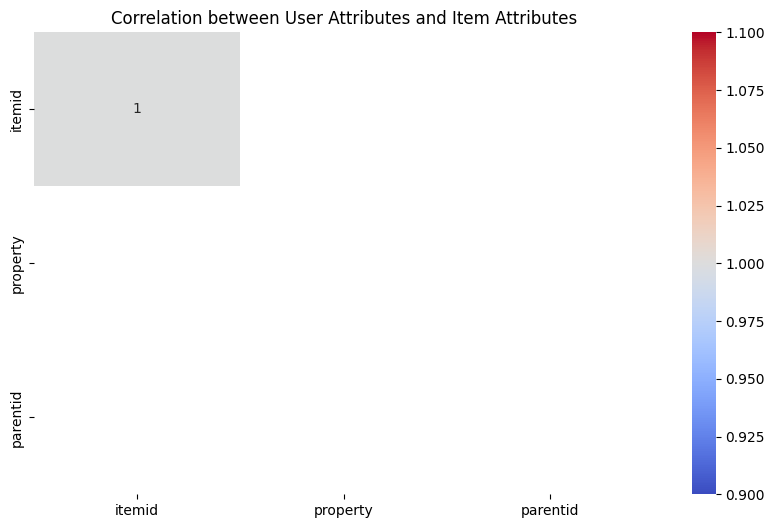

In [37]:
#Correlation between user attributes and item attributes
user_item_merged = merged_events.groupby('visitorid').agg({
    'itemid': 'count',
    'property': 'nunique',
    'parentid': 'nunique',
})
print(user_item_merged.head().reset_index())

correlation_matrix = user_item_merged.corr()
print(correlation_matrix)

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,annot =True,cmap ='coolwarm')
plt.title('Correlation between User Attributes and Item Attributes')
plt.show()

In [38]:
#Add-to-cart to transaction conversion rate

add_to_cart = event_df[event_df['event'] == 'addtocart']
transactions = event_df[event_df['event'] == 'transaction']
conversion_rate = len(transactions) / len(add_to_cart)

print(f"Add-to-cart to transaction conversion rate: {conversion_rate:.2%}")

Add-to-cart to transaction conversion rate: 32.56%


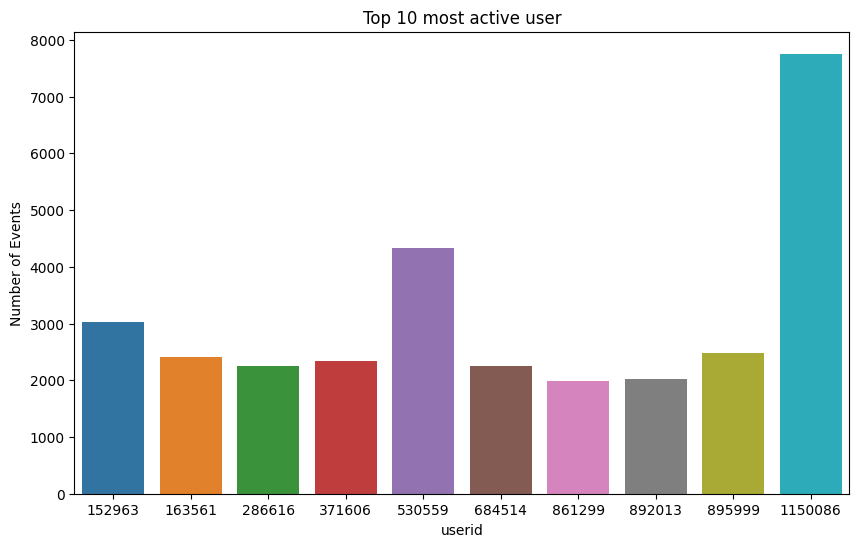

In [39]:
# 10. Most active users
top_active_user = event_df['visitorid'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_active_user.index,y=top_active_user.values)
plt.title('Top 10 most active user')
plt.xlabel('userid')
plt.ylabel('Number of Events')
plt.show()

In [40]:
merged_events.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5,NaN,NaN,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5,NaN,NaN,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5,NaN,NaN,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5,NaN,NaN,NaN,NaN


**feature engineering**

**After performing the exploratory data analysis, this section is about feature engineering to extract relevant information for the collaborative filtering model**


**User-based features**: Extract information about user behavior, such as average time spent on the platform, average number of items viewed, and average number of items added to cart. We can also compute the average time between actions (e.g., view, add to cart, and transaction)

**Item-based features**: Compute item popularity based on the number of views, add to carts, and transactions. Additionally, we can calculate the average time an item spends in the cart before being purchased or removed

**User-item interaction features**: Calculate the frequency of user-item interactions and the average time between interactions. These features will help determine how often a user interacts with a specific item and how much time passes between interactions

**Category-based features**: Compute category popularity based on the number of views and transactions for items in each category. This information can be useful for identifying popular categories and understanding user preferences

**Timestamp-based features**: Extract information from timestamps, such as day of the week, hour of the day, or time since the last event. These features can help identify patterns in user behavior and item interactions

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error
from surprise import Reader,Dataset,SVD
from surprise.model_selection import cross_validate,GridSearchCV

In [42]:
df = merged_events.copy()


In [43]:
df.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,Tuesday,5,NaN,NaN,NaN,NaN
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,Tuesday,5,NaN,NaN,NaN,NaN
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,Tuesday,5,NaN,NaN,NaN,NaN
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,Tuesday,5,NaN,NaN,NaN,NaN
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,Tuesday,5,NaN,NaN,NaN,NaN


In [44]:
df.shape

(2755641, 12)

In [45]:
#lets take sample
np.random.seed(1)

rows_to_keep = np.random.choice(df.index, size=100000, replace=False)
sample_df = df.loc[rows_to_keep]

# Display the sampled DataFrame
sample_df


,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
1502186,1430801768576,1163548,view,182851,NaN,2015-05-05 04:56:08.576,Tuesday,4,NaN,NaN,NaN,NaN
547399,1435378506816,519492,view,287287,NaN,2015-06-27 04:15:06.816,Saturday,4,NaN,NaN,NaN,NaN
2152452,1436078633332,532358,view,347081,NaN,2015-07-05 06:43:53.332,Sunday,6,NaN,NaN,NaN,NaN
1508392,1430851366672,1394708,view,354881,NaN,2015-05-05 18:42:46.672,Tuesday,18,NaN,NaN,NaN,NaN
628172,1438579567615,1174103,view,78887,NaN,2015-08-03 05:26:07.615,Monday,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
603512,1435694949972,692135,view,404825,NaN,2015-06-30 20:09:09.972,Tuesday,20,NaN,NaN,NaN,NaN
751354,1439099414315,722421,view,137144,NaN,2015-08-09 05:50:14.315,Sunday,5,NaN,NaN,NaN,NaN
649947,1438624688773,1144723,view,62228,NaN,2015-08-03 17:58:08.773,Monday,17,NaN,NaN,NaN,NaN
2334499,1436820023832,448128,view,260819,NaN,2015-07-13 20:40:23.832,Monday,20,NaN,NaN,NaN,NaN


In [46]:
sample_df.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,property,value,categoryid,parentid
1502186,1430801768576,1163548,view,182851,NaN,2015-05-05 04:56:08.576,Tuesday,4,NaN,NaN,NaN,NaN
547399,1435378506816,519492,view,287287,NaN,2015-06-27 04:15:06.816,Saturday,4,NaN,NaN,NaN,NaN
2152452,1436078633332,532358,view,347081,NaN,2015-07-05 06:43:53.332,Sunday,6,NaN,NaN,NaN,NaN
1508392,1430851366672,1394708,view,354881,NaN,2015-05-05 18:42:46.672,Tuesday,18,NaN,NaN,NaN,NaN
628172,1438579567615,1174103,view,78887,NaN,2015-08-03 05:26:07.615,Monday,5,NaN,NaN,NaN,NaN


In [47]:
 #feature engineering 
#user_based Feature

user_behavior = sample_df.groupby('visitorid').agg({
    'itemid':'count',
    'property': 'nunique',
    'parentid':'nunique',
    'timestamp': ['min' ,'max','mean']
}).reset_index()

user_behavior.columns = ['visitorid', 'item_count', 'property_count', 'category_count', 'first_interaction', 'last_interaction', 'avg_interaction_time']
user_behavior['time_on_platform'] = user_behavior['last_interaction'] - user_behavior['first_interaction']
user_behavior['time_between_actions'] = user_behavior['time_on_platform'] / (user_behavior['item_count'] - 1)

user_behavior

,visitorid,item_count,property_count,category_count,first_interaction,last_interaction,avg_interaction_time,time_on_platform,time_between_actions
0,2,1,0,0,1438970905669,1438970905669,1.438971e+12,0,NaN
1,6,1,0,0,1440914628202,1440914628202,1.440915e+12,0,NaN
2,88,1,0,0,1442086733371,1442086733371,1.442087e+12,0,NaN
3,120,1,0,0,1436023859041,1436023859041,1.436024e+12,0,NaN
4,137,1,0,0,1433149153810,1433149153810,1.433149e+12,0,NaN
...,...,...,...,...,...,...,...,...,...
87717,1407491,1,0,0,1441657541978,1441657541978,1.441658e+12,0,NaN
87718,1407494,1,0,0,1434394598580,1434394598580,1.434395e+12,0,NaN
87719,1407504,1,0,0,1439656228164,1439656228164,1.439656e+12,0,NaN
87720,1407530,1,0,0,1437964161007,1437964161007,1.437964e+12,0,NaN


In [48]:
#item_based feature
item_popularity = sample_df.groupby('itemid').agg({
    'visitorid':'count',
     'event': ['nunique',lambda  x : sum(x == 'view'),
              lambda x:sum(x =='addtocart'),
              lambda x:sum(x =='transaction')]
   }).reset_index()

item_popularity.columns=['itemid','user_count','event_count','view_count','addtocart_count','transaction_count']
item_popularity['conversion rate'] = item_popularity['transaction_count']/item_popularity['addtocart_count']
item_popularity

,itemid,user_count,event_count,view_count,addtocart_count,transaction_count,conversion rate
0,3,1,1,1,0,0,NaN
1,6,1,1,1,0,0,NaN
2,15,1,1,0,1,0,0.0
3,19,2,1,2,0,0,NaN
4,32,3,1,3,0,0,NaN
...,...,...,...,...,...,...,...
50079,466857,1,1,1,0,0,NaN
50080,466858,1,1,1,0,0,NaN
50081,466860,1,1,1,0,0,NaN
50082,466861,1,1,1,0,0,NaN


In [49]:
#user_item interaction feature
user_item_interaction = sample_df.groupby(['visitorid' ,'itemid']).agg({
    'event':'count',
    'timestamp' : ['min' ,'max']
    }).reset_index()
user_item_interaction.columns =['visitorid','itemid' ,'interaction_count','first_interaction','last_interaction']
user_item_interaction['time_between_interaction'] = user_item_interaction['last_interaction'] -user_item_interaction['first_interaction']
user_item_interaction

,visitorid,itemid,interaction_count,first_interaction,last_interaction,time_between_interaction
0,2,342816,1,1438970905669,1438970905669,0
1,6,65273,1,1440914628202,1440914628202,0
2,88,58827,1,1442086733371,1442086733371,0
3,120,153339,1,1436023859041,1436023859041,0
4,137,383819,1,1433149153810,1433149153810,0
...,...,...,...,...,...,...
97972,1407491,445239,1,1441657541978,1441657541978,0
97973,1407494,3125,1,1434394598580,1434394598580,0
97974,1407504,406296,1,1439656228164,1439656228164,0
97975,1407530,455539,1,1437964161007,1437964161007,0


In [50]:

user_feature=user_behavior.drop(['first_interaction' ,'last_interaction'],axis=1)
item_feature=item_popularity.drop(['view_count','addtocart_count','transaction_count'],axis=1)
user_item_interaction_feature=user_item_interaction.drop(['first_interaction','last_interaction'],axis=1)

#merge the feature into single dataframe, preparing features for a machine learning model by combining information from different DataFrames 

features=user_item_interaction_feature.merge(user_feature,on ='visitorid').merge(item_feature, on ='itemid')


In [51]:
features.head()

,visitorid,itemid,interaction_count,time_between_interaction,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,2,342816,1,0,1,0,0,1.438971e+12,0,NaN,6,1,NaN
1,228860,342816,1,0,1,0,0,1.437159e+12,0,NaN,6,1,NaN
2,916244,342816,1,0,1,0,0,1.433721e+12,0,NaN,6,1,NaN
3,1059763,342816,1,0,2,0,0,1.432230e+12,197097,197097.0,6,1,NaN
4,1148730,342816,1,0,1,0,0,1.432776e+12,0,NaN,6,1,NaN


In [52]:
import random 

# Replace infinity values with NaN
features=features.replace([np.inf,-np.inf],np.nan)

# Fill NaN values with the median
features=features.fillna(features.median())
features.head(10)

,visitorid,itemid,interaction_count,time_between_interaction,item_count,property_count,category_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,2,342816,1,0,1,0,0,1.438971e+12,0,4.087350e+07,6,1,0.0
1,228860,342816,1,0,1,0,0,1.437159e+12,0,4.087350e+07,6,1,0.0
2,916244,342816,1,0,1,0,0,1.433721e+12,0,4.087350e+07,6,1,0.0
3,1059763,342816,1,0,2,0,0,1.432230e+12,197097,1.970970e+05,6,1,0.0
4,1148730,342816,1,0,1,0,0,1.432776e+12,0,4.087350e+07,6,1,0.0
5,1264860,342816,1,0,1,0,0,1.430862e+12,0,4.087350e+07,6,1,0.0
6,6,65273,1,0,1,0,0,1.440915e+12,0,4.087350e+07,42,2,0.0
7,19033,65273,1,0,1,0,0,1.441406e+12,0,4.087350e+07,42,2,0.0
8,172280,65273,1,0,1,0,0,1.437916e+12,0,4.087350e+07,42,2,0.0
9,173863,65273,1,0,37,0,0,1.440536e+12,4049600794,1.124889e+08,42,2,0.0



1. **Visualize interactions**: Create visualizations to explore the relationship between the engineered features and user-item interactions. This can help us identify patterns and trends in the data.

2. **Data preprocessing**: Split the data into training and testing sets. Normalize the features to ensure they are on the same scale, which is essential for collaborative filtering algorithms.

3. **Implement collaborative filtering**: Choose an appropriate collaborative filtering method (e.g., user-based, item-based, or matrix factorization). Train the model on the training data and evaluate its performance using metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).

4. **Model tuning**: Fine-tune the model's hyperparameters to optimize its performance. We can use techniques like grid search or random search to find the best set of hyperparameters for teh model.

5. **Model evaluation**: Evaluate the final model on the testing data to assess its performance. Compare the results with a baseline model, such as a simple popularity-based recommender, to ensure that the collaborative filtering model offers improved recommendations.


In [53]:
### Data preprocessing
## Split the data

train_data ,test_data = train_test_split(features,test_size =0.2,random_state=42)

## Normalize the features
scaler = MinMaxScaler()
train_data_normalized = scaler.fit_transform(train_data)
test_data_normalized = scaler.transform(test_data)


In [54]:
# Collaborative filtering using matrix factorization (SVD)
reader = Reader(rating_scale =(0,1))
train_dataset=Dataset.load_from_df(train_data[['visitorid' ,'itemid','interaction_count']],reader)

# covert train_dataset into specific format
trainset=train_dataset.build_full_trainset()

In [55]:
#perform hyperparameter tuning for an SVD (Singular Value Decomposition) recommendation model using grid search. 

param_grid = {'n_factors': [10, 50, 100], 'n_epochs': [20, 50], 'lr_all': [0.002, 0.005], 'reg_all': [0.02, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)


In [56]:
# fits the GridSearchCV object to the training dataset
gs.fit(train_dataset)

In [57]:
# Best hyperparameters
best_params = gs.best_params['rmse']
print(f"best hyperparameter for RSME :{best_params}")

best hyperparameter for RSME :{'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.002, 'reg_all': 0.1}


In [58]:
# Train the model with the best hyperparameters
algo =SVD(n_factors=best_params['n_factors'],n_epochs=best_params['n_epochs'],lr_all=best_params['lr_all'],reg_all=best_params['reg_all'])
algo.fit(trainset)

#model evalution
testset=list(zip(test_data['visitorid'].values, test_data['itemid'].values, test_data['interaction_count'].values))
prediction=algo.test(testset)

In [59]:
# Calculate evaluation metrics
MAE = mean_absolute_error(test_data['interaction_count'],[pred.est for pred in prediction])
MSE = mean_squared_error(test_data['interaction_count'],[pred.est for pred in prediction])
rmse = np.sqrt(MSE)

print(f"Mean Absolute Error: {MAE}")
print(f"Mean Squared Error: {MSE}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 0.020643768202398625
Mean Squared Error: 0.03193887284807233
Root Mean Squared Error: 0.17871450094514527
